# **Childproofing - Heavy Objects - Boston**
## Notebook V 1.2

## Description
The notebook is designed to walk you through the project that was assigned to us - which consists of detecting heavy objects that might potentially endenger children (infants, toddlers, pre-schoolers and school-aged-children). 
For our approach, we chose to opt for a multi-label classifier, to correctly identify those objects.

A multi-label classifier is, in our sense, the best method to deal with real-estate, because images may contain a variety of objects, either safe or not safe, the Neural Network needs to correctly distinguish between every object present in a photograph, and only alerts us if a dangerous object is detected.

For example, if an image contains a safe furniture and an unsafe TV, the CNN needs to understand what is dangerous and what is safe, hence, a multi-labeling approach. Illustrations will be displayed, to have furhter context about the model.

The Fastai Library offers a good environement to work on multi-labeling, but in order for it to fully capture the images, the dataset had to be adjusted in a certain way. In contrast to binary or multi-classification, Fastai requires the images not to be in separate folders, but rather in one single folder, labeled via a CSV File. 

In [0]:
from fastai.vision import *
from google.colab import drive
import seaborn as sns
from matplotlib.pyplot import figure

Starting by importing the relevent libraries:

1.   fastai.vision for modeling
2.   google.colab for data accessing 
3.   matplotlib and seaborn for data visualization





# **1. EDA**

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
ls '/content/drive/My Drive/'

 2.5kdata/          'Dressers OK'/   finale/      Multi-Label-Test/   Test-AI/
 all/                filename.csv    kitchen/    'NOT OK Dressers'/   THIS/
'Colab Notebooks'/   Final/         'Mess (2)'/   T1/


In [0]:
path = Path('/content/drive/My Drive/2.5kdata/')

In [0]:
ls '/content/drive/My Drive/T1'

Files/  finalenames.csv


The data is contained in the T1 folder - labels are in 'finalnames.csv' and the images are in sub folder 'Files'

In [5]:
df = pd.read_csv( '/content/drive/My Drive/2.5kdata/labels.csv') ; df.head()

names labels
0     safe (1).jpg   safe
1    safe (10).jpg   safe
2   safe (100).jpg   safe
3  safe (1000).jpg   safe
4  safe (1001).jpg   safe

Using Pandas DataFrame to display the data, which consists of labels for our images...

In [6]:
df.labels.value_counts()

safe                          1112
unsafe_kitchen                 447
unsafe_furniture               355
unsafe_tv                      302
unsafe_tv unsafe_furniture      75
unsafe_tv safe                  35
Name: labels, dtype: int64

Here we display the number of images per class...

In [7]:
len(df.labels)

2326

And the total length of the entire dataset.

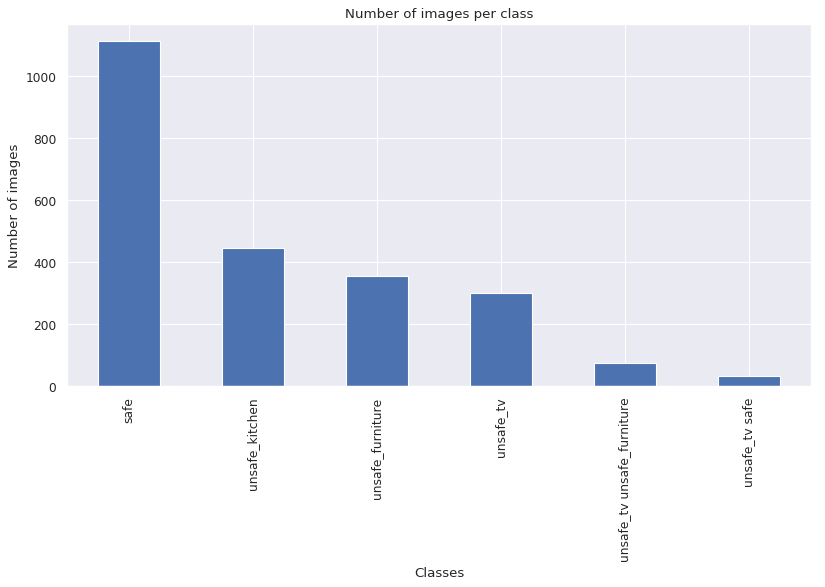

In [9]:
sns.set()
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Number of images per class')
plt.ylabel('Number of images')
plt.xlabel('Classes')
df.labels.value_counts().plot.bar()

Using Matplotlib and Seaborn, the above Histogram shows how many unique images we have per class.

In [0]:
one_label = len(df[df.labels == 'safe']) + len(df[df.labels == 'unsafe_kitchen']) + len(df[df.labels == 'unsafe_tv']) + len(df[df.labels == 'unsafe_furniture'])
two_labels = len(df[df.labels == 'unsafe_tv unsafe_furniture']) + len(df[df.labels == 'unsafe_tv safe'])

<BarContainer object of 2 artists>

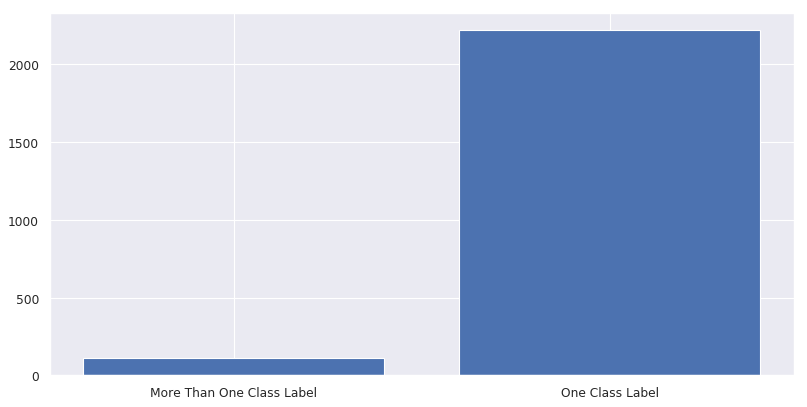

In [13]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(['More Than One Class Label', 'One Class Label'], [two_labels, one_label])

And here, the histogram displays how many images belong to more than one class at the same time (ex: Safe Furniture and Unsafe TV)

In [14]:
df.isna().sum()

names     0
labels    0
dtype: int64

Making sure there are no null values.

# 2. Modeling

Here, we created a data object using the ImageList class, which can take any kind of DataLoader class and Dataset class, provided a path to the dataset, the name of the .csv file (since we utilized the method .from_csv), defined the path to the images, and how the different categories can be separated (label_delim = '   '). We also included data augmentation (get_transforms). 

The data object created will then be incorporated in the model.



In [0]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, '/content/drive/My Drive/2.5kdata/labels.csv', folder='')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

In [20]:
data.classes

['safe', 'unsafe_furniture', 'unsafe_kitchen', 'unsafe_tv']

We have four separate classes: 



*   Unsafe Furniture
*   Unsafe Kitchen
*   Unsafe TVs
*   Negative Class: Safe

We also have a combination of two classes:


1.   Unsafe TVs/Unsafe Furniture
2.   Unsafe TVs/Negative Class







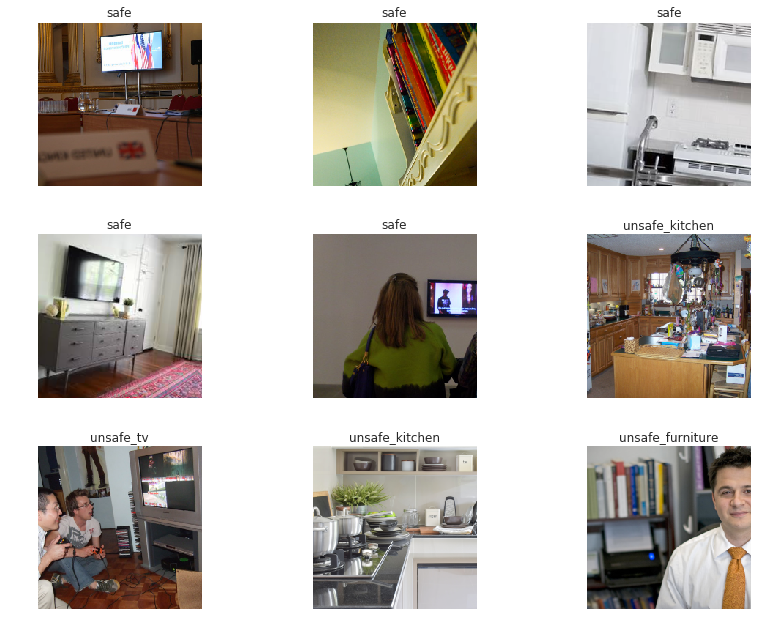

In [21]:
data.show_batch(rows=3, figsize=(12,9))

To have a sense about our data, above we displayed 9 different images. Some of them belong to unique classes, and some of them belong to two classes (separated by ';')

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
learn = cnn_learner(data, models.resnet34, metrics=[acc_02])

Using Resnet34, we create a CNN with 'accuracy_thresh' of 0.2 as a metric of evaluation. The main idea behind this is to make the model know that if an image has at least 20% chance of being labled in a category X, it needs to be included in the model prediction. In contrast to other types of classification, where the sum of all the predictions add up to 100%, multi-labeling does not use the same approach. Technically, we use the sum of binary cross entropies of each labels.

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


lr_find() method to find the optimal learning rate for the dataset.

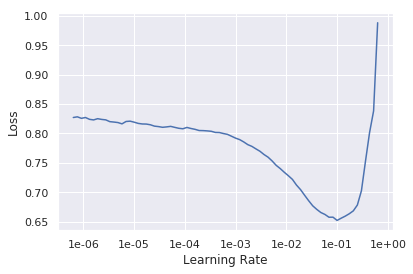

In [25]:
learn.recorder.plot()

The optimal learning rate here is somewhere between 0.01 and 0.001

In [26]:
learn.fit_one_cycle(8, (0.5e-02))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

101 misclassified samples over 465 samples in the validation set.


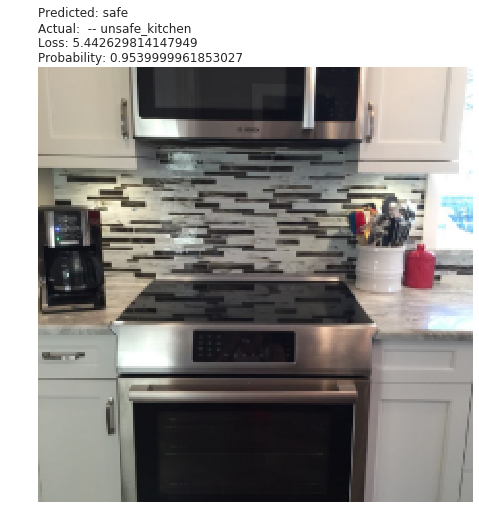

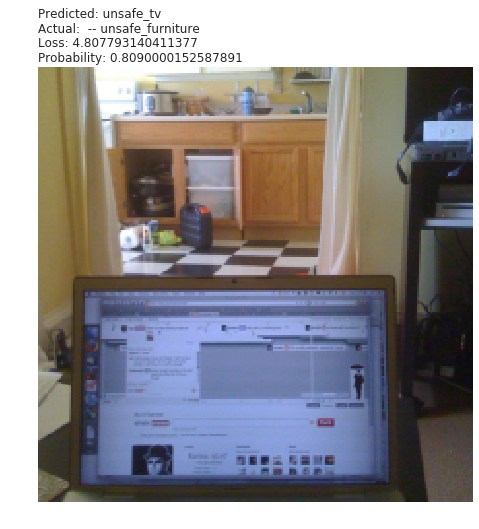

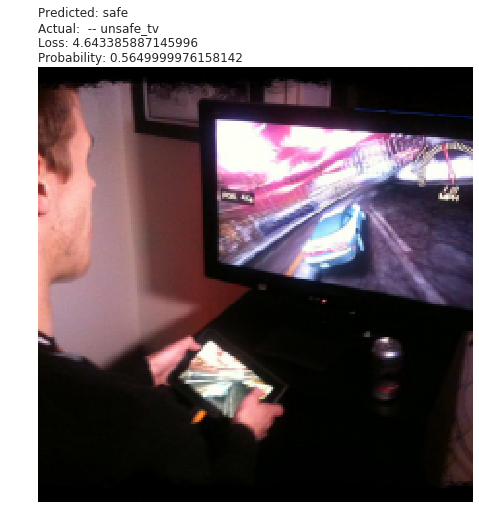

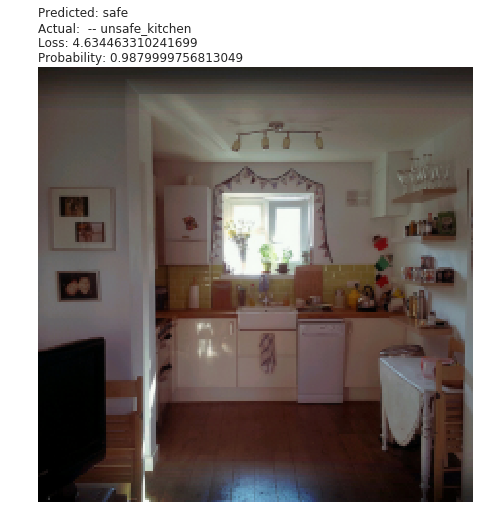

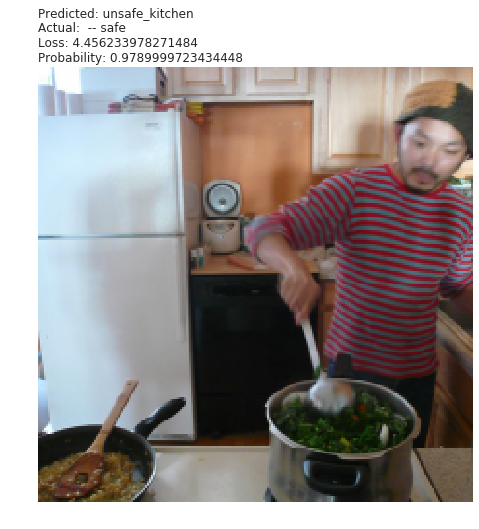

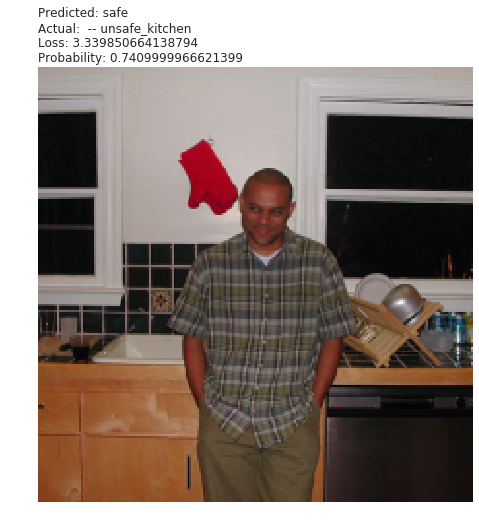

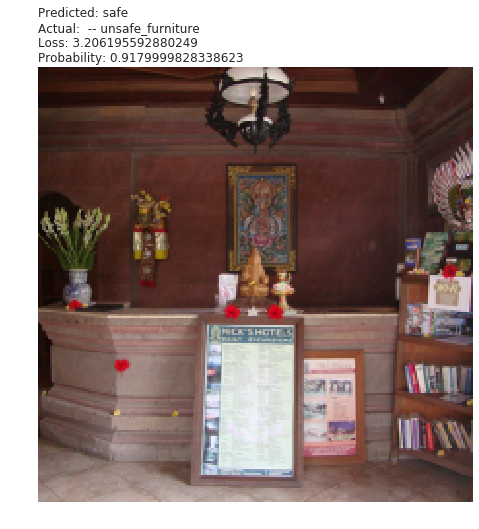

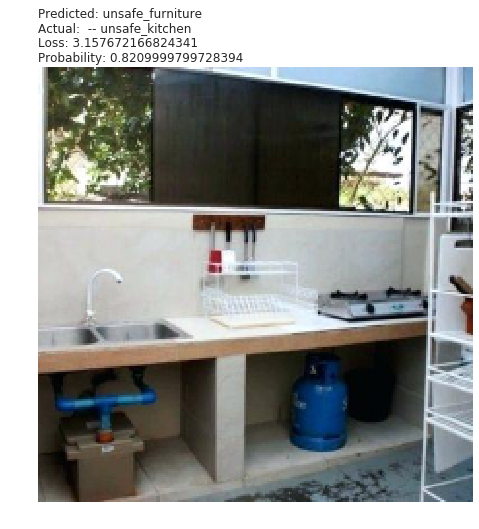

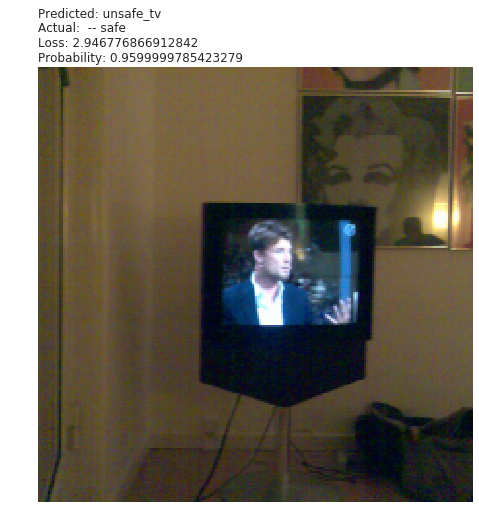

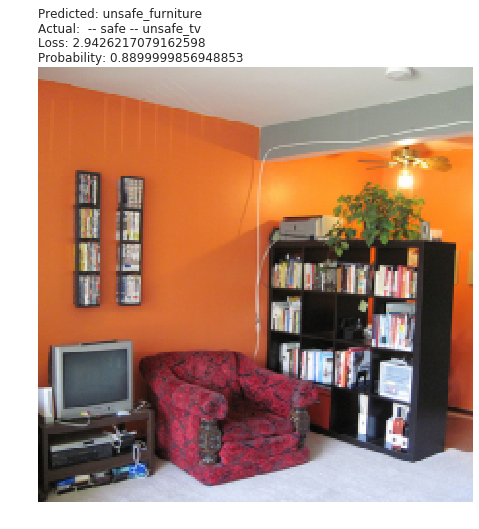

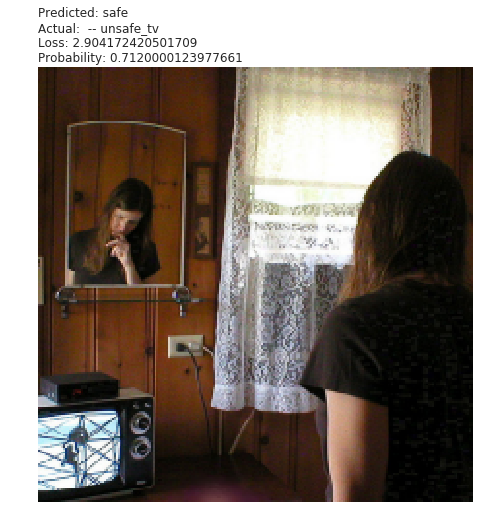

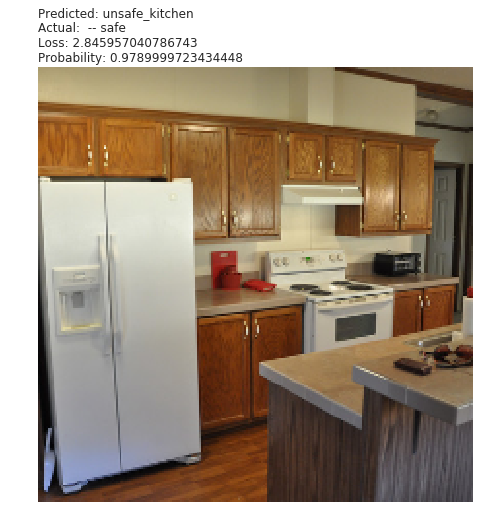

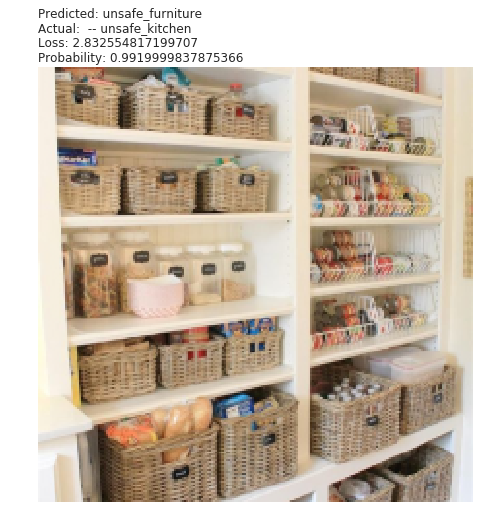

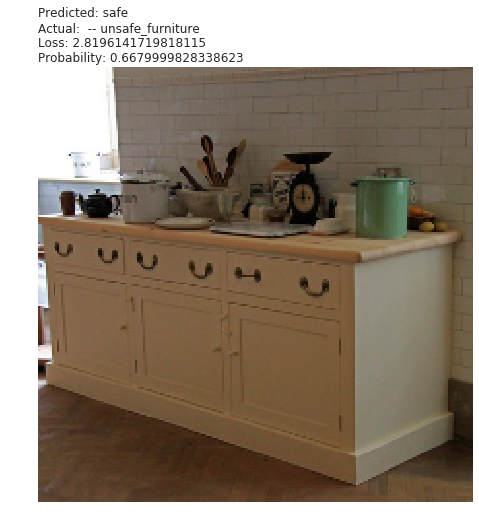

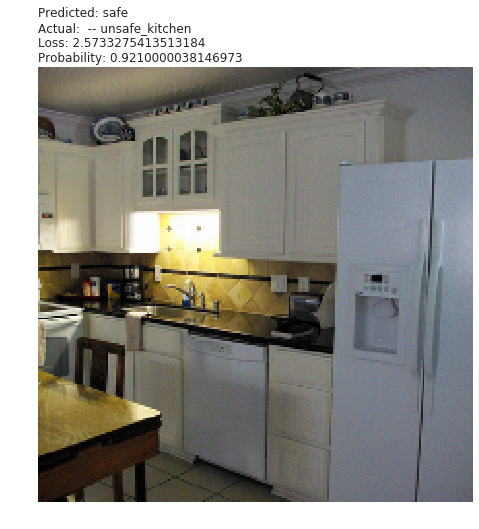

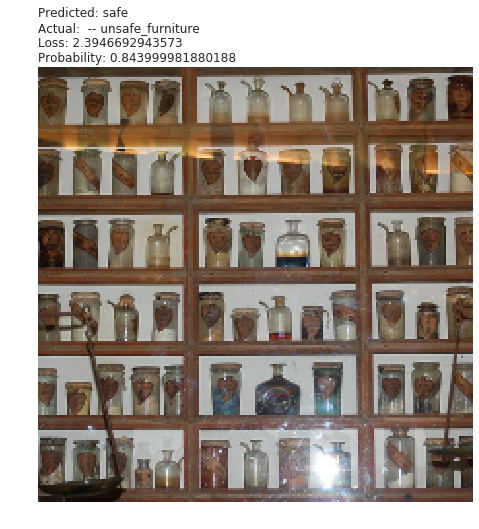

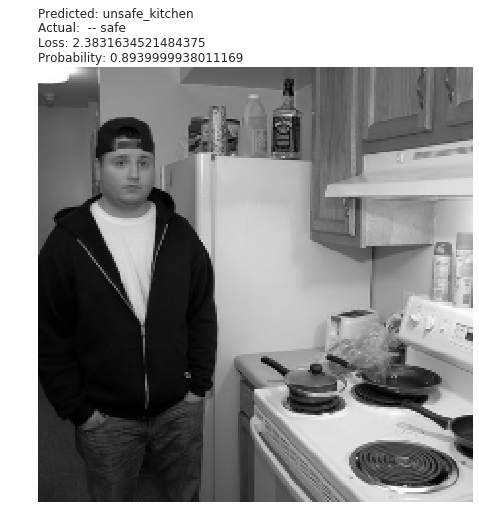

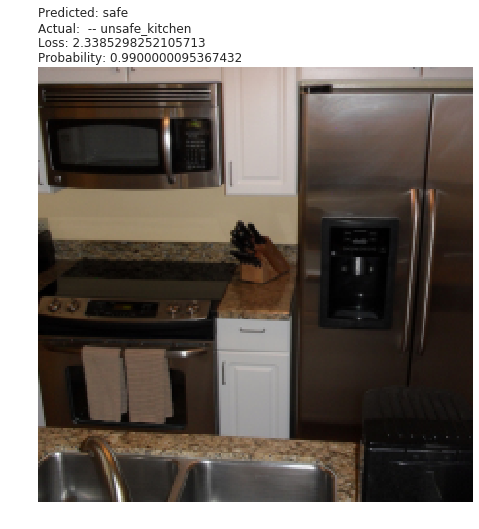

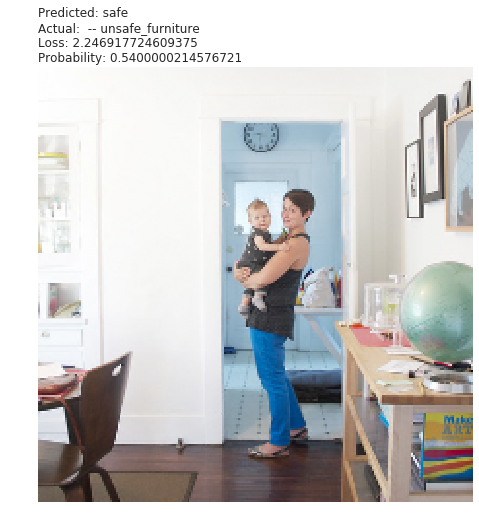

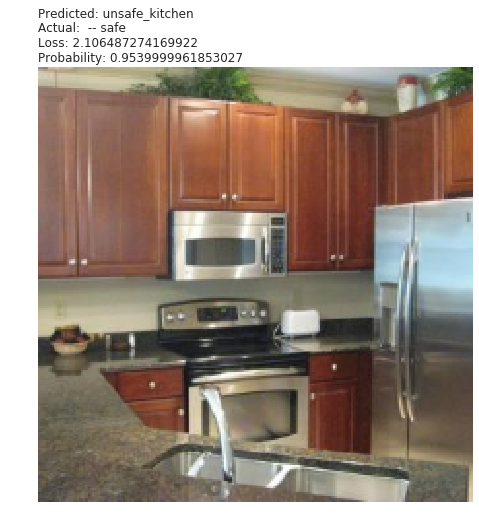

In [29]:
interp.plot_multi_top_losses(samples=20)

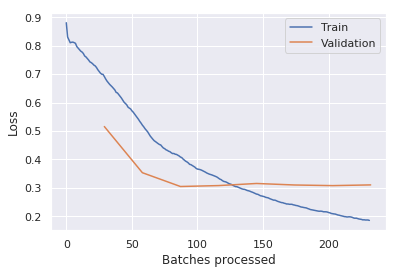

In [30]:
learn.recorder.plot_losses()

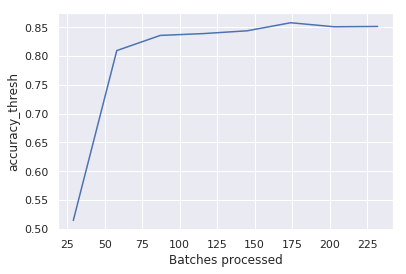

In [31]:
learn.recorder.plot_metrics()

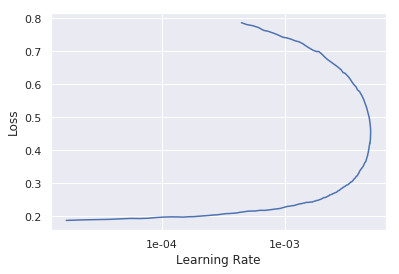

In [32]:
learn.recorder.plot()

In [0]:
learn.save('/content/drive/My Drive/T1/finaldatatest')